<a href="https://colab.research.google.com/github/wilselby/diy_driverless_car_ROS/blob/ml-model/rover_ml/colab/RC_Car_End_to_End_Image_Regression_with_CNNs_(Lidar).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Development of an End-to-End ML Model for Navigating an RC car with a Lidar

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/wilselby/diy_driverless_car_ROS/blob/ml-model/RC_Car_End_to_End_Image_Regression_with_CNNs_(RGB_camera).ipynb">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />
    Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/wilselby/diy_driverless_car_ROS/blob/ml-model/rover_ml/colab/RC_Car_End_to_End_Image_Regression_with_CNNs_(RGB_camera).ipynb">
    <img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />
    View source on GitHub</a>
  </td>
</table>

#Environment Setup


## Import Dependencies

In [1]:
import os
import csv
import cv2
import matplotlib.pyplot as plt
import random
import pprint

import numpy as np
from numpy import expand_dims

%tensorflow_version 1.x
import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)

from keras import backend as K
from keras.models import Model, Sequential
from keras.models import load_model
from keras.layers import Dense, GlobalAveragePooling2D, MaxPooling2D, Lambda, Cropping2D
from keras.layers.convolutional import Convolution2D
from keras.layers.core import Flatten, Dense, Dropout, SpatialDropout2D
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array 
   
from google.colab.patches import cv2_imshow
  
import sklearn
from sklearn.model_selection import train_test_split
import pandas as pd

print("Tensorflow Version:",tf.__version__)
print("Tensorflow Keras Version:",tf.keras.__version__)
print("Eager mode: ", tf.executing_eagerly())


Using TensorFlow backend.


('Tensorflow Version:', '1.15.0')
('Tensorflow Keras Version:', '2.2.4-tf')
('Eager mode: ', False)


## Confirm TensorFlow can see the GPU 

Simply select "GPU" in the Accelerator drop-down in Notebook Settings (either through the Edit menu or the command palette at cmd/ctrl-shift-P).

In [2]:
device_name = tf.test.gpu_device_name()

if device_name != '/device:GPU:0':
  # Raise SystemError('GPU device not found')
  print('GPU device not found')
else:
  print('Found GPU at: {}'.format(device_name))
  
  # GPU count and name
  !nvidia-smi -L

Found GPU at: /device:GPU:0
GPU 0: Tesla P100-PCIE-16GB (UUID: GPU-47aa6e31-82c5-f73d-7d78-373fb85348e8)


# Load the Dataset

## Download and Extract the Dataset

In [3]:
# Download the dataset
!curl -O https://selbystorage.s3-us-west-2.amazonaws.com/research/office_3/office_3.tar.gz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  257M  100  257M    0     0  23.9M      0  0:00:10  0:00:10 --:--:-- 54.1M


In [4]:
data_set = 'office_3'
tar_file = data_set + '.tar.gz'

# Unzip the .tgz file
# -x for extract
# -v for verbose 
# -z for gnuzip
# -f for file (should come at last just before file name)
# -C to extract the zipped contents to a different directory
!tar -xvzf $tar_file

office_3/
office_3/ml_training_2019-12-26-14-59-40_12.yaml
office_3/ml_training_2019-12-28-10-32-38_7.yaml
office_3/camera.csv
office_3/ml_training_2019-12-26-14-54-02_0.yaml
office_3/ml_training_2019-12-28-10-31-15_5.yaml
office_3/ml_training_2019-12-26-14-54-58_2.yaml
office_3/ml_training_2019-12-26-14-59-11_11.yaml
office_3/ml_training_2019-12-28-10-30-32_4.yaml
office_3/ml_training_2019-12-26-14-55-25_3.yaml
office_3/.~lock.interpolated.csv#
office_3/ml_training_2019-12-26-14-58-43_10.yaml
office_3/ml_training_2019-12-26-14-57-46_8.yaml
office_3/ml_training_2019-12-26-14-56-50_6.yaml
office_3/ml_training_2019-12-28-10-27-15_0.yaml
office_3/interpolated.csv
office_3/steering.csv
office_3/ml_training_2019-12-26-14-57-18_7.yaml
office_3/ml_training_2019-12-28-10-29-24_3.yaml
office_3/ml_training_2019-12-26-14-54-30_1.yaml
office_3/ml_training_2019-12-28-10-31-56_6.yaml
office_3/ml_training_2019-12-28-10-28-42_2.yaml
office_3/ml_training_2019-12-28-10-28-00_1.yaml
office_3/ml_training_

## Parse the CSV File

In [44]:
# Define path to csv file
csv_path = data_set + '/interpolated.csv'

# Load the CSV file into a pandas dataframe
df = pd.read_csv(csv_path, sep=",")

# Print the dimensions
print("Dataset Dimensions:")
print(df.shape)

# Print the first 5 lines of the dataframe for review
print("\nDataset Summary:")
df.head(5)
  

Dataset Dimensions:
(6253, 8)

Dataset Summary:


,index,timestamp,width,height,frame_id,filename,angle,speed
0,2019-12-26 22:54:03.912922880,1577400843912922880,1024,64,NaN,center/1577400843912922880.jpg,0.0,0.0
1,2019-12-26 22:54:03.963078912,1577400843963078912,1024,64,NaN,center/1577400843963078912.jpg,0.0,0.0
2,2019-12-26 22:54:04.013053184,1577400844013053184,1024,64,NaN,center/1577400844013053184.jpg,0.0,0.0
3,2019-12-26 22:54:04.063207680,1577400844063207680,1024,64,NaN,center/1577400844063207680.jpg,0.0,0.0
4,2019-12-26 22:54:04.113175552,1577400844113175552,1024,64,NaN,center/1577400844113175552.jpg,0.0,0.0


# Clean and Pre-process the Dataset

## Remove Unneccessary Columns

In [45]:
# Remove 'index' and 'frame_id' columns 
df.drop(['index','frame_id'],axis=1,inplace=True)

# Verify new dataframe dimensions
print("Dataset Dimensions:")
print(df.shape)

# Print the first 5 lines of the new dataframe for review
print("\nDataset Summary:")
df.head(5)

Dataset Dimensions:
(6253, 6)

Dataset Summary:


,timestamp,width,height,filename,angle,speed
0,1577400843912922880,1024,64,center/1577400843912922880.jpg,0.0,0.0
1,1577400843963078912,1024,64,center/1577400843963078912.jpg,0.0,0.0
2,1577400844013053184,1024,64,center/1577400844013053184.jpg,0.0,0.0
3,1577400844063207680,1024,64,center/1577400844063207680.jpg,0.0,0.0
4,1577400844113175552,1024,64,center/1577400844113175552.jpg,0.0,0.0


## Detect Missing Data

In [46]:
# Detect Missing Values
print("Any Missing Values?: {}".format(df.isnull().values.any()))

# Total Sum
print("\nTotal Number of Missing Values: {}".format(df.isnull().sum().sum()))

# Sum Per Column
print("\nTotal Number of Missing Values per Column:")
print(df.isnull().sum())

Any Missing Values?: False

Total Number of Missing Values: 0

Total Number of Missing Values per Column:
timestamp    0
width        0
height       0
filename     0
angle        0
speed        0
dtype: int64


## Remove Zero Throttle Values

In [47]:
# Determine if any throttle values are zeroes
print("Any 0 throttle values?: {}".format(df['speed'].eq(0).any()))

# Determine number of 0 throttle values:
print("\nNumber of 0 throttle values: {}".format(df['speed'].eq(0).sum()))

# Remove rows with 0 throttle values
if df['speed'].eq(0).any():
  df = df.query('speed != 0')
  
  # Reset the index
  df.reset_index(inplace=True,drop=True)
  
# Verify new dataframe dimensions
print("\nNew Dataset Dimensions:")
print(df.shape)
df.head(5)

Any 0 throttle values?: True

Number of 0 throttle values: 55

New Dataset Dimensions:
(6198, 6)


,timestamp,width,height,filename,angle,speed
0,1577400844263394816,1024,64,center/1577400844263394816.jpg,0.0,0.002261
1,1577400844313359616,1024,64,center/1577400844313359616.jpg,0.0,0.006871
2,1577400844363330560,1024,64,center/1577400844363330560.jpg,0.0,0.011482
3,1577400844413312256,1024,64,center/1577400844413312256.jpg,0.0,0.016252
4,1577400844463289088,1024,64,center/1577400844463289088.jpg,0.0,0.021229


## View Label Statistics

In [9]:
# Steering Command Statistics
print("\nSteering Command Statistics:")
print(df['angle'].describe())

print("\nThrottle Command Statistics:")
# Throttle Command Statistics
print(df['speed'].describe())


Steering Command Statistics:
count    6198.000000
mean        0.822324
std         1.008619
min        -1.533349
25%         0.471148
50%         1.380756
75%         1.466080
max         1.531508
Name: angle, dtype: float64

Throttle Command Statistics:
count    6198.000000
mean        0.129354
std         0.015255
min         0.002261
25%         0.118947
50%         0.131835
75%         0.139840
max         0.150000
Name: speed, dtype: float64


## View Histogram of Steering Commands

<BarContainer object of 25 artists>

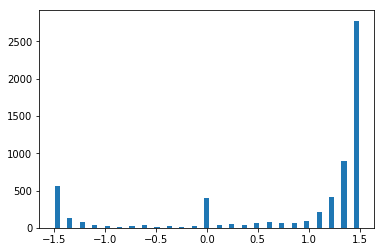

In [48]:
#@title Select the number of histogram bins

num_bins = 25 #@param {type:"slider", min:5, max:50, step:1}

hist, bins = np.histogram(df['angle'], num_bins)
center = (bins[:-1]+ bins[1:]) * 0.5
plt.bar(center, hist, width=0.05)
#plt.plot((np.min(df['angle']), np.max(df['angle'])), (samples_per_bin, samples_per_bin))

In [0]:
# Normalize the histogram (150-300 for RBG)
#@title Normalize the Histogram { run: "auto" }
hist = False #@param {type:"boolean"}

remove_list = []
samples_per_bin = 150

if hist:
  for j in range(num_bins):
    list_ = []
    for i in range(len(df['angle'])):
      if df.loc[i,'angle'] >= bins[j] and df.loc[i,'angle'] <= bins[j+1]:
        list_.append(i)
    random.shuffle(list_)
    list_ = list_[samples_per_bin:]
    remove_list.extend(list_)

  print('removed:', len(remove_list))
  df.drop(df.index[remove_list], inplace=True)
  df.reset_index(inplace=True)
  df.drop(['index'],axis=1,inplace=True)
  print('remaining:', len(df))
  
  hist, _ = np.histogram(df['angle'], (num_bins))
  plt.bar(center, hist, width=0.05)
  plt.plot((np.min(df['angle']), np.max(df['angle'])), (samples_per_bin, samples_per_bin))

## View a Sample Image

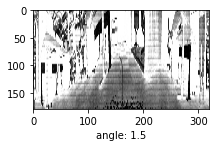

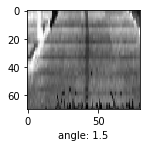

In [49]:
# View a Single Image 
index = random.randint(0,df.shape[0]-1)

img_name = data_set + '/' + df.loc[index,'filename']
angle = df.loc[index,'angle']

center_image = cv2.imread(img_name)
center_image_mod = cv2.resize(center_image, (320,180))
center_image_mod = cv2.cvtColor(center_image_mod,cv2.COLOR_RGB2BGR)

# Crop the image
height_min = 100 
height_max = 170
width_min = 120
width_max = 200
bottom_crop = center_image_mod.shape[0] - height_max
right_crop = center_image_mod.shape[1] - width_max

crop_img = center_image_mod[height_min:height_max, width_min:width_max]

plt.subplot(2,1,1)
plt.imshow(center_image_mod)
plt.grid(False)
plt.xlabel('angle: {:.2}'.format(angle))
plt.show() 

plt.subplot(2,1,2)
plt.imshow(crop_img)
plt.grid(False)
plt.xlabel('angle: {:.2}'.format(angle))
plt.show() 

## View Multiple Images

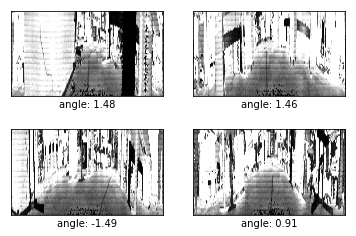

In [13]:
# Number of Images to Display
num_images = 4

# Display the images
i = 0
for i in range (i,num_images):
    index = random.randint(0,df.shape[0]-1)
    image_path = df.loc[index,'filename']
    angle = df.loc[index,'angle']
    img_name = data_set + '/' + image_path
    image = cv2.imread(img_name)
    image = cv2.resize(image, (320,180))
    image = cv2.cvtColor(image,cv2.COLOR_RGB2BGR)
    plt.subplot(num_images/2,num_images/2,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(image, cmap=plt.cm.binary)
    plt.xlabel('angle: {:.3}'.format(angle))
    i += 1

# Split the Dataset

## Define an ImageDataGenerator to Augment Images



In [0]:
# Create image data augmentation generator and choose augmentation types
datagen = ImageDataGenerator(
                             #rotation_range=20,
                             zoom_range=0.15,
                             #width_shift_range=0.1,
                             #height_shift_range=0.2,
                             #shear_range=10,
                             brightness_range=[0.5,1.0],
                          	 #horizontal_flip=True,
                             #vertical_flip=True,
                             #channel_shift_range=100.0,
                             fill_mode="reflect")

## View Image Augmentation Examples

Augmenting a Single Image: 



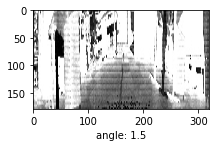

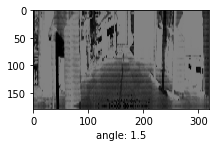

Multiple Augmentations: 



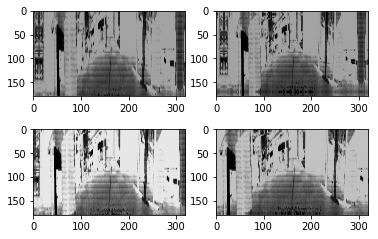

In [50]:
# load the image
index = random.randint(0,df.shape[0]-1)

img_name = data_set + '/' + df.loc[index,'filename']
original_image = cv2.imread(img_name)
original_image = cv2.cvtColor(original_image,cv2.COLOR_RGB2BGR)
original_image = cv2.resize(original_image, (320,180))
label = df.loc[index,'angle']

# convert to numpy array
data = img_to_array(original_image)

# expand dimension to one sample
test = expand_dims(data, 0)

# prepare iterator
it = datagen.flow(test, batch_size=1)

# generate batch of images
batch = it.next()

# convert to unsigned integers for viewing
image_aug = batch[0].astype('uint8')

print("Augmenting a Single Image: \n")

plt.subplot(2,1,1)
plt.imshow(original_image)
plt.grid(False)
plt.xlabel('angle: {:.2}'.format(label))
plt.show() 

plt.subplot(2,1,2)
plt.imshow(image_aug)
plt.grid(False)
plt.xlabel('angle: {:.2}'.format(label))
plt.show() 

print("Multiple Augmentations: \n")
# generate samples and plot
for i in range(0,num_images):
	# define subplot
	plt.subplot(num_images/2,num_images/2,i+1)
	# generate batch of images
	batch = it.next()
	# convert to unsigned integers for viewing
	image = batch[0].astype('uint8')
	# plot raw pixel data
	plt.imshow(image)
# show the figure
plt.show()


## Define a Data Generator

In [0]:
def generator(samples, batch_size=32, aug=0):
    num_samples = len(samples)

    while 1:  # Loop forever so the generator never terminates
        for offset in range(0, num_samples, batch_size):
            batch_samples = samples[offset:offset + batch_size]

            #print(batch_samples)
            images = []
            angles = []
            for batch_sample in batch_samples:
                if batch_sample[5] != "filename":
                    name = data_set + '/' + batch_sample[3]
                    center_image = cv2.imread(name)
                    center_image = cv2.cvtColor(center_image,cv2.COLOR_RGB2BGR)
                    center_image = cv2.resize(
                        center_image,
                        (320, 180))  #resize from 720x1280 to 180x320
                    angle = float(batch_sample[4])
                    if not aug:
                      images.append(center_image)
                      angles.append(angle)
                    else:
                        data = img_to_array(center_image)
                        sample = expand_dims(data, 0)
                        it = datagen.flow(sample, batch_size=1)
                        batch = it.next()
                        image_aug = batch[0].astype('uint8')
                        if random.random() < .5:
                          image_aug = np.fliplr(image_aug)
                          angle = -1 * angle
                        images.append(image_aug)
                        angles.append(angle)

            X_train = np.array(images)
            y_train = np.array(angles)

            yield sklearn.utils.shuffle(X_train, y_train)

## Split the Dataset

In [52]:
samples = []

samples = df.values.tolist()

sklearn.utils.shuffle(samples)
train_samples, validation_samples = train_test_split(samples, test_size=0.2)

print("Number of traing samples: ", len(train_samples))
print("Number of validation samples: ", len(validation_samples))

('Number of traing samples: ', 4958)
('Number of validation samples: ', 1240)


## Define Training and Validation Data Generators

In [0]:
batch_size_value = 32
img_aug = 1

train_generator = generator(train_samples, batch_size=batch_size_value, aug=img_aug)
validation_generator = generator(
    validation_samples, batch_size=batch_size_value, aug=0)

# Compile and Train the Model

## Build the Model

In [54]:
# Initialize the model
model = Sequential()

# trim image to only see section with road
# (top_crop, bottom_crop), (left_crop, right_crop)
model.add(Cropping2D(cropping=((height_min,bottom_crop), (width_min,right_crop)), input_shape=(180,320,3)))

# Preprocess incoming data, centered around zero with small standard deviation
model.add(Lambda(lambda x: (x / 255.0) - 0.5))

# Nvidia model
model.add(Convolution2D(24, (5, 5), activation="relu", name="conv_1", strides=(2, 2)))
model.add(Convolution2D(36, (5, 5), activation="relu", name="conv_2", strides=(2, 2)))
model.add(Convolution2D(48, (5, 5), activation="relu", name="conv_3", strides=(2, 2)))
model.add(SpatialDropout2D(.5, dim_ordering='default'))

model.add(Convolution2D(64, (3, 3), activation="relu", name="conv_4", strides=(1, 1)))
model.add(Convolution2D(64, (3, 3), activation="relu", name="conv_5", strides=(1, 1)))

model.add(Flatten())

model.add(Dense(1164))
model.add(Dropout(.5))
model.add(Dense(100, activation='relu'))
model.add(Dropout(.5))
model.add(Dense(50, activation='relu'))
model.add(Dropout(.5))
model.add(Dense(10, activation='relu'))
model.add(Dropout(.5))
model.add(Dense(1))

model.compile(loss='mse', optimizer=Adam(lr=0.001), metrics=['mse','mae','mape','cosine'])

# Print model sumamry
model.summary()

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:14: UserWarning: Update your `SpatialDropout2D` call to the Keras 2 API: `SpatialDropout2D(0.5, data_format=None)`
  


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cropping2d_3 (Cropping2D)    (None, 70, 80, 3)         0         
_________________________________________________________________
lambda_3 (Lambda)            (None, 70, 80, 3)         0         
_________________________________________________________________
conv_1 (Conv2D)              (None, 33, 38, 24)        1824      
_________________________________________________________________
conv_2 (Conv2D)              (None, 15, 17, 36)        21636     
_________________________________________________________________
conv_3 (Conv2D)              (None, 6, 7, 48)          43248     
_________________________________________________________________
spatial_dropout2d_3 (Spatial (None, 6, 7, 48)          0         
_________________________________________________________________
conv_4 (Conv2D)              (None, 4, 5, 64)          27712     
__________

## Setup Checkpoints

In [0]:
# checkpoint
model_path = './model'

!if [ -d $model_path ]; then echo 'Directory Exists'; else mkdir $model_path; fi

filepath = model_path + "/weights-improvement-{epoch:02d}-{val_loss:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='auto', period=1)

## Setup Early Stopping to Prevent Overfitting

In [0]:
# The patience parameter is the amount of epochs to check for improvement
early_stop = EarlyStopping(monitor='val_loss', patience=10)

## Reduce Learning Rate When a Metric has Stopped Improving

In [0]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=5, min_lr=0.001)

## Setup Tensorboard

In [25]:
# Clear any logs from previous runs
!rm -rf ./Graph/ 

# Launch Tensorboard
!pip install -U tensorboardcolab

from tensorboardcolab import *

tbc = TensorBoardColab()

# Configure the Tensorboard Callback
tbCallBack = TensorBoard(log_dir='./Graph', 
                        histogram_freq=1,
                        write_graph=True,
                        write_grads=True,
                        write_images=True,
                        batch_size=batch_size_value,
                        update_freq='epoch')


Requirement already up-to-date: tensorboardcolab in /usr/local/lib/python2.7/dist-packages (0.0.22)
Wait for 8 seconds...
TensorBoard link:
http://5deaa30c.ngrok.io


## Load Existing Model

In [38]:
load = True #@param {type:"boolean"}

if load:
  # Returns a compiled model identical to the previous one
  !curl -O https://selbystorage.s3-us-west-2.amazonaws.com/research/office_3/model_intensity.h5
  !mv model_intensity.h5 model/
  model_path_full = model_path + '/' + 'model_intensity.h5'
  model = load_model(model_path_full)
  print("Loaded previous model: {} \n".format(model_path_full))
else:
  print("No previous model loaded \n")

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 8297k  100 8297k    0     0  10.4M      0 --:--:-- --:--:-- --:--:-- 10.4M
Loaded previous model: ./model/model_intensity.h5 




## Train the Model

In [0]:
# Define step sizes
STEP_SIZE_TRAIN = len(train_samples) / batch_size_value
STEP_SIZE_VALID = len(validation_samples) / batch_size_value

# Define number of epochs
n_epoch = 50

# Define callbacks
# callbacks_list = [TensorBoardColabCallback(tbc)]
# callbacks_list = [TensorBoardColabCallback(tbc), early_stop]
# callbacks_list = [TensorBoardColabCallback(tbc), early_stop, checkpoint]
callbacks_list = [TensorBoardColabCallback(tbc), early_stop, checkpoint, reduce_lr]

# Fit the model
history_object = model.fit_generator(
    generator=train_generator,
    steps_per_epoch=STEP_SIZE_TRAIN,
    validation_data=validation_generator,
    validation_steps=STEP_SIZE_VALID,
    callbacks=callbacks_list,
    use_multiprocessing=True,
    epochs=n_epoch)


Epoch 1/50
154/154 [==============================] - 87s 563ms/step - loss: 1.6989 - mean_squared_error: 1.6989 - mean_absolute_error: 1.2303 - mean_absolute_percentage_error: 2537433.2419 - cosine_proximity: -0.0099 - val_loss: 1.7245 - val_mean_squared_error: 1.7245 - val_mean_absolute_error: 1.2423 - val_mean_absolute_percentage_error: 359371.0461 - val_cosine_proximity: 0.6513

Epoch 00001: val_loss did not improve from 0.25825
Epoch 2/50
154/154 [==============================] - 84s 544ms/step - loss: 1.6901 - mean_squared_error: 1.6901 - mean_absolute_error: 1.2264 - mean_absolute_percentage_error: 1111287.3951 - cosine_proximity: 0.0278 - val_loss: 1.7239 - val_mean_squared_error: 1.7239 - val_mean_absolute_error: 1.2447 - val_mean_absolute_percentage_error: 135715.2303 - val_cosine_proximity: 0.6531

Epoch 00002: val_loss did not improve from 0.25825
Epoch 3/50
154/154 [==============================] - 84s 547ms/step - loss: 1.6869 - mean_squared_error: 1.6869 - mean_absolut

Process PoolWorker-5:
Traceback (most recent call last):
Process PoolWorker-6:
Traceback (most recent call last):
  File "/usr/lib/python2.7/multiprocessing/process.py", line 267, in _bootstrap
  File "/usr/lib/python2.7/multiprocessing/process.py", line 267, in _bootstrap
    self.run()
  File "/usr/lib/python2.7/multiprocessing/process.py", line 114, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python2.7/multiprocessing/pool.py", line 102, in worker
    self.run()
    task = get()
  File "/usr/lib/python2.7/multiprocessing/process.py", line 114, in run
  File "/usr/lib/python2.7/multiprocessing/queues.py", line 376, in get
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python2.7/multiprocessing/pool.py", line 113, in worker
    result = (True, func(*args, **kwds))
  File "/usr/local/lib/python2.7/dist-packages/keras/utils/data_utils.py", line 626, in next_sample
    return recv()
KeyboardInterrupt
    return six.next(_SHARED_SEQUENCES[uid])
  

## Save the Model

In [0]:
# Save model
model_path_full = model_path + '/'

model.save(model_path_full + 'model.h5')
with open(model_path_full + 'model.json', 'w') as output_json:
    output_json.write(model.to_json())

# Evaluate the Model

## Plot the Training Results

Generating loss chart...
Done.


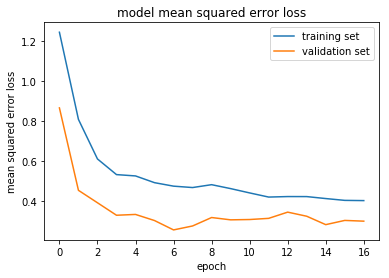

In [29]:
# Plot the training and validation loss for each epoch
print('Generating loss chart...')
plt.plot(history_object.history['loss'])
plt.plot(history_object.history['val_loss'])
plt.title('model mean squared error loss')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')
plt.savefig(model_path + '/model.png')

# Done
print('Done.')

## Print Performance Metrics

In [39]:
scores = model.evaluate_generator(validation_generator, STEP_SIZE_VALID, use_multiprocessing=True)

metrics_names = model.metrics_names

for i in range(len(model.metrics_names)):
  print("Metric: {} - {}".format(metrics_names[i],scores[i]))


Metric: loss - 0.190782873646
Metric: mean_squared_error - 0.190782873646
Metric: mean_absolute_error - 0.330186681136
Metric: mean_absolute_percentage_error - 28329829.3002
Metric: cosine_proximity - -0.870888157895


## Compute Prediction Statistics

200/200 [==============================] - 0s 381us/step
[INFO] mean: 22781.22%, std: 143750.05%
count    200.000000
mean      -0.069993
std        0.367974
min       -0.937922
25%       -0.275053
50%       -0.170840
75%       -0.080705
max        1.389061
dtype: float64


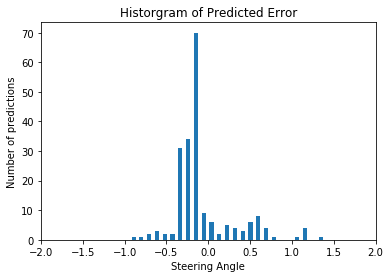

In [41]:
# Define image loading function
def load_images(dataframe):
  
  # initialize images array
  images = []
  
  for i in dataframe.index.values:
    name = data_set + '/' + dataframe.loc[i,'filename']
    center_image = cv2.imread(name)
    center_image = cv2.resize(center_image, (320,180))
    images.append(center_image)
    
  return np.array(images)
  
# Load images 
test_size = 200
df_test = df.sample(frac=1).reset_index(drop=True)
df_test = df_test.head(test_size)

test_images = load_images(df_test)

batch_size = 32
preds = model.predict(test_images, batch_size=batch_size, verbose=1)

#print("Preds: {} \n".format(preds))

testY = df_test.iloc[:,4].values

#print("Labels: {} \n".format(testY))

df_testY = pd.Series(testY)
df_preds = pd.Series(preds.flatten)

# Replace 0 angle values
if df_testY.eq(0).any():
  df_testY.replace(0, 0.0001,inplace=True)

# Calculate the difference
diff = preds.flatten() - df_testY
percentDiff = (diff / testY) * 100
absPercentDiff = np.abs(percentDiff)

# compute the mean and standard deviation of the absolute percentage
# difference
mean = np.mean(absPercentDiff)
std = np.std(absPercentDiff)
print("[INFO] mean: {:.2f}%, std: {:.2f}%".format(mean, std))

# Compute the mean and standard deviation of the difference
print(diff.describe())

# Plot a histogram of the prediction errors
num_bins = 25
hist, bins = np.histogram(diff, num_bins)
center = (bins[:-1]+ bins[1:]) * 0.5
plt.bar(center, hist, width=0.05)
plt.title('Historgram of Predicted Error')
plt.xlabel('Steering Angle')
plt.ylabel('Number of predictions')
plt.xlim(-2.0, 2.0)
plt.plot(np.min(diff), np.max(diff))

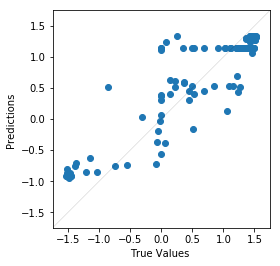

In [43]:
# Plot a Scatter Plot of the Error
plt.scatter(testY, preds)
plt.xlabel('True Values ')
plt.ylabel('Predictions ')
plt.axis('equal')
plt.axis('square')
plt.xlim([-1.75,1.75])
plt.ylim([-1.75,1.75])
plt.plot([-1.75, 1.75], [-1.75, 1.75], color='k', linestyle='-', linewidth=.1)

## Plot a Prediction

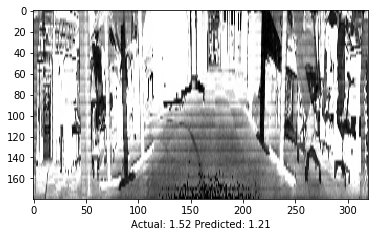

In [33]:
# Plot the image with the actual and predicted steering angle
index = random.randint(0,df_test.shape[0]-1)
img_name = data_set + '/' + df_test.loc[index,'filename']
center_image = cv2.imread(img_name)
center_image = cv2.cvtColor(center_image,cv2.COLOR_RGB2BGR)
center_image_mod = cv2.resize(center_image, (320,180)) 
plt.imshow(center_image_mod)
plt.grid(False)
plt.xlabel('Actual: {:.2f} Predicted: {:.2f}'.format(df_test.loc[index,'angle'],float(preds[index])))
plt.show() 


#Visualize the Network


##Show the Model Summary

In [0]:
model.summary()

##Access Individual Layers

In [0]:
# Creating a mapping of layer name ot layer details 
# We will create a dictionary layers_info which maps a layer name to its charcteristics
layers_info = {}
for i in model.layers:
    layers_info[i.name] = i.get_config()

# Here the layer_weights dictionary will map every layer_name to its corresponding weights
layer_weights = {}
for i in model.layers:
    layer_weights[i.name] = i.get_weights()

pprint.pprint(layers_info['conv_5'])

##Visualize the Filters

In [0]:
# Visualize the first filter of each convolution layer
layers = model.layers
layer_ids = [2,3,4,6,7]

#plot the filters
fig,ax = plt.subplots(nrows=1,ncols=5)
for i in range(5):
    ax[i].imshow(layers[layer_ids[i]].get_weights()[0][:,:,:,0][:,:,0],cmap='gray')
    ax[i].set_title('Conv'+str(i+1))
    ax[i].set_xticks([])
    ax[i].set_yticks([])

##Visualize the Saliency Map


In [34]:
!pip install -I scipy==1.2.*
!pip install git+https://github.com/raghakot/keras-vis.git -U

# import specific functions from keras-vis package
from vis.utils import utils
from vis.visualization import visualize_saliency, visualize_cam, overlay

     |████████████████████████████████| 24.8MB 126kB/s 
     |████████████████████████████████| 17.0MB 222kB/s 
ERROR: tensorflow 1.15.0 has requirement tensorflow-estimator==1.15.1, but you'll have tensorflow-estimator 1.15.0 which is incompatible.
ERROR: fastai 0.7.0 has requirement torch<0.4, but you'll have torch 1.3.1+cu100 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.


  Cloning https://github.com/raghakot/keras-vis.git to /tmp/pip-req-build-mXIKbH
  Running command git clone -q https://github.com/raghakot/keras-vis.git /tmp/pip-req-build-mXIKbH
  Created wheel for keras-vis: filename=keras_vis-0.5.0-py2.py3-none-any.whl size=38887 sha256=133fa4adce41ffb9168829b645bce2d2b33ad6795a9e36e99b49a49db5340c54
  Stored in directory: /tmp/pip-ephem-wheel-cache-vfftza/wheels/c5/ae/e7/b34d1cb48b1898f606a5cce08ebc9521fa0588f37f1e590d9f
Successfully built keras-vis
  Found existing installation: keras-vis 0.4.1
    Uninstalling keras-vis-0.4.1:
      Successfully uninstalled keras-vis-0.4.1


In [0]:
# View a Single Image 
index = random.randint(0,df.shape[0]-1)
img_name = data_set + '/' + df.loc[index,'filename']

sample_image = cv2.imread(img_name)
sample_image = cv2.cvtColor(sample_image,cv2.COLOR_RGB2BGR)
sample_image_mod = cv2.resize(sample_image, (320,180))
plt.imshow(sample_image_mod)
 
layer_idx = utils.find_layer_idx(model, 'conv_5')

grads = visualize_saliency(model, 
                           layer_idx, 
                           filter_indices=None, 
                           seed_input=sample_image_mod,
                           grad_modifier='absolute',
                           backprop_modifier='guided')

plt.imshow(grads, alpha = 0.6)

# References:
[Keras, Regression, and CNNs](https://www.pyimagesearch.com/2019/01/28/keras-regression-and-cnns/)

[Regression with Keras](https://www.pyimagesearch.com/2019/01/21/regression-with-keras/)

[How to use Keras fit and fit_generator](https://www.pyimagesearch.com/2018/12/24/how-to-use-keras-fit-and-fit_generator-a-hands-on-tutorial/)

[Image Classification with Convolutional Neural Networks](https://colab.research.google.com/github/tensorflow/examples/blob/master/courses/udacity_intro_to_tensorflow_for_deep_learning/l04c01_image_classification_with_cnns.ipynb#scrollTo=7MqDQO0KCaWS)

[Keras Image Processing Documentation](https://keras.io/preprocessing/image/)

[Attribution.ipynb](https://colab.research.google.com/github/idealo/cnn-exposed/blob/master/notebooks/Attribution.ipynb#scrollTo=jqSOW0pQniCw)

[A Guide to Understanding Convolutional Neural Networks (CNNs) using Visualization](https://www.analyticsvidhya.com/blog/2019/05/understanding-visualizing-neural-networks/)

[Visualizing attention on self driving car](https://github.com/raghakot/keras-vis/blob/master/applications/self_driving/visualize_attention.ipynb)

[Exploring Image Data Augmentation with Keras and Tensorflow](https://towardsdatascience.com/exploring-image-data-augmentation-with-eras-and-tensorflow-a8162d89b844
)

[Tensorboard Documentation](https://keras.io/callbacks/#tensorboard)